In [33]:
import sympy
from sympy import powdenest
from IPython.display import display
from einsteinpy.symbolic import MetricTensor, ChristoffelSymbols

def inner_prod(vec1: list, vec2: list, metric: MetricTensor):
  """returns the inner product of vec1 and vec2 with respect to the supplied metric

  Args:
    vec1 (list): first vector, once contravariant
    vec2 (list): second vector, once contravariant
    metric (MetricTensor): metric tensor, twice covariant

  Returns:
    symbolic sympy expression: inner product of vec1 with vec2 with respect to
    the specified metric tensor
  """
  ans = 0
  for a in range(len(vec1)):
    for b in range(len(vec2)):
      ans = ans + vec1[a]*vec2[b]*metric.arr[a][b]
  return powdenest(ans.simplify(), force=True)

def normalize(vec: list, metric: MetricTensor):
  """normalizes the input vector with respect to the supplied metric tensor

  Args:
    vec (list[sympy expressions]): components of the vector to be normalised
    metric (MetricTensor): metric tensor used to define the vector norm

  Returns: None
  """
  norm = sympy.sqrt(inner_prod(vec, vec, metric))
  vec[:] = [powdenest((cmp / norm).simplify(), force=True) for cmp in vec]
  
def calc_hesse(coords: list, g: MetricTensor, V):
  """returns the components of the covariant Hesse matrix in a twice-covariant
  form. Components for all pairs of the supplied coordinates are calculated for
  the scalar potential V using the supplied metric tensor.
  
  The components of the covariant Hesse matrix are defined as:
    V_ab(ϕ) = ∇_a ∇_b V(ϕ)
  This is expanded as (using Einstein notation):
    V_ab(ϕ) = ∇_a (∂_b V(ϕ)) = ∂_a ∂_b V(ϕ) - Γ_ab^c(ϕ) ∂_c V(ϕ)
  Where Γ_ab^c(ϕ) is the standard Christoffel connection defined as:
    Γ_ab^c = 1/2 g^cd (∂_a g_bd + ∂_b g_ad - ∂_d g_ab)

  Args:
    coords (list[sympy symbols]): coordinates (scalar fields) with respect to
      which the components of the Hesse matrix are defined
    g (MetricTensor): metric tensor to be used to raise/lower indices and define
      the covariant derivative
    V (sympy expression): expression for the scalar potential of the inflaton
      fields.

  Returns:
    list[list[sympy expressions]]: nested list of components of the Hesse matrix
  """
  dim = len(coords)
  #The connection has indices up-down-down (opposite order that we usually use)
  conn = ChristoffelSymbols.from_metric(g).tensor()
  #output components of the Hesse matrix
  Vab = [[0 for _ in range(dim)] for _ in range(dim)]
  
  for a in range(dim):
    for b in range(dim):
      #Calculate ∂_a ∂_b V(ϕ)
      da_dbV = sympy.diff(V, coords[b], coords[a]).simplify()
      #Calculate the contraction Γ_ab^c(ϕ) ∂_c V(ϕ)
      gamma_ab = 0
      for c in range(dim):
        gamma_ab = (gamma_ab + conn[c][b][a]*sympy.diff(V, coords[c])).simplify()
      #set the output components
      Vab[a][b] = (da_dbV - gamma_ab).simplify()
  return Vab

def calc_v(coords: list, g: MetricTensor, V):
  """calculates a normalized vector pointing in the direction of the gradient of
  the supplied scalar potential

  Args:
    coords (list[sympy symbols]): coordinates (scalar fields) with respect to
      which the potential and its gradient are defined
    g (MetricTensor): metric tensor of the scalar manifold (used to calculate
      covariant derivatives)
    V (sympy expression): scalar potential
    
  The contravariant components of the gradient of V are given by:
    (grad V)^a(ϕ) = g^ab(ϕ) ∂_b V(ϕ)

  Returns:
    list[sympy expression]: contravariant components of normalized gradient vector
      v.
  """
  dim = len(coords)
  #non-normalised components of grad V
  v = [sympy.diff(V, φ) for φ in coords]  
  
  #contract v with the inverse of the metric tensor
  for a in range(dim):
    for b in range(dim):
      v[a] = (v[a] + powdenest(g.inv().arr[a][b] * v[a], force=True)).simplify()
  
  #normalize v
  normalize(v, g)
  return v

def calc_next_w(current_basis: list, guess: list, g: MetricTensor):
  f"""Use the Gramm-Schmidt procedure to find a new orthogonal basis vector given
  an incomplete set of orthogonal basis vectors and a third vector that is linearly
  independent from the other vectors.

  Args:
    current_basis (list(list)): list of current *orthogonal* basisvectors. The
      components of the vectors should be given in *contravariant* form.
    guess (list): vector that is linearly independent from the (incomplete) set of
      current basis vectors. The components of this vector should be given in
      *contravariant* form. This vector needn't be normalized nor orthogonal to
      the set of current basis vectors.
    g (MetricTensor): metric tensor (twice covariant) used to define inner products
      for the Gramm-Schmidt procedure
      
  The Gramm-Schmidt procedure starts with a(n incomplete) set of orthonormal
  basis vectors x_i and new vector y that is linearly independent of all x_i. We
  then simply subtract the overlap between y and each basisvector to obtain a
  vector x_i+1 that is orthogonal to all x_i:
    x_i+1 = y - Σ_a g_ij x^i_a y^j
  The final step is to normalise x_i+1

  Returns:
    (list): list of the contravariant components of an additional basis vector
      orthogonal to the supplied set of basis vectors, with respect to the supplied
      metric.
  """
  dim = len(current_basis[0])
  #make sure the supplied basis is not already complete
  assert(len(current_basis) < dim)
  
  #start with vector y
  y = guess
  
  #subtract the overlap of each current basis vector from y
  for x in current_basis:
    #first assert that vec is actually normalised
    #assert(sympy.Eq(inner_prod(x, x, g), 1))
    xy = inner_prod(x, guess, g) #we have to use guess here, not y!
    y = [(y_a - xy*x_a).simplify() for (y_a, x_a) in zip(y, x)]
    
  #normalize y
  normalize(y, g)
  return y

def project_hesse(hesse_matrix: list, vec1: list, vec2: list):
  """_summary_

  Args:
    hesse_matrix (list[list[sympy expression]]): twice-covariant components of
      the Hesse matrix
    vec1 (list[sympy expression]): first vector along which to project the Hesse
      matrix
    vec2 (list[sympy expression]): second vector along which to project the Hesse
      matrix

  Returns:
      _type_: _description_
  """
  dim = len(vec1)
  assert(len(vec1) == len(vec2))
  V_proj = 0
  for a in range(dim):
    for b in range(dim):
      V_proj = V_proj + hesse_matrix[a][b]*vec1[a]*vec2[b]
  return powdenest(V_proj.simplify(), force=True)

In [34]:
sympy.init_printing()
f, g = sympy.symbols("f g")
V0, f0, g0, m = sympy.symbols("V0 f0 g0 m")
coords = [f, g]
d = 2

metric = [[0 for i in range(2)] for i in range(2)]
metric[0][0] = 1
metric[1][1] = g**2
metric = MetricTensor(metric, (f, g))
V = (V0 - g0*g + 1/2*(m**2)*((f-f0)**2)).nsimplify()
display(metric.tensor())
display(V)

⎡1  0 ⎤
⎢     ⎥
⎢    2⎥
⎣0  g ⎦

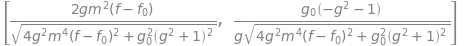

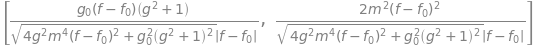

In [35]:
#Calculate the gradient basis
basis = [calc_v(coords, metric, V)]
display(basis[0])
for i in range(d - 1):
  next_guess = [0 for _ in range(d)]
  next_guess[i + 1] = 1
  w = calc_next_w(basis, next_guess, metric)
  display(w)
  basis.append(w)

In [36]:
#sanity check
for a in range(d):
  for b in range(d):
    print(f"w[{a}]*w[{b}]={inner_prod(basis[a], basis[b], metric)}")

w[0]*w[0]=1
w[0]*w[1]=0
w[1]*w[0]=0
w[1]*w[1]=1


In [37]:
H = calc_hesse(coords, metric, V)
display(sympy.Matrix(H))

⎡ 2    ⎤
⎢m   0 ⎥
⎢      ⎥
⎢    g₀⎥
⎢0   ──⎥
⎣    g ⎦

H00=


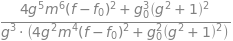

H01=


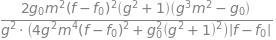

H10=


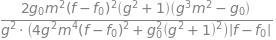

H11=


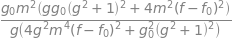

In [38]:
from joblib import Parallel, delayed
def process(a:int, b:int):
  return ([a, b], project_hesse(H, basis[a], basis[b]))

H_proj = [[0 for _ in range(d)] for _ in range(d)]
results = Parallel(n_jobs=8)(delayed(process)(a, b) for a in range(d) for b in range(d))
for (idx, result) in results:
  H_proj[idx[0]][idx[1]] = result
  print(f"H{idx[0]}{idx[1]}=")
  display(result)

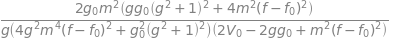

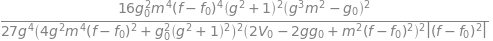

In [39]:
display((H_proj[1][1]/V).simplify())
display((1/27*(H_proj[0][1]/V)**2).nsimplify().simplify())

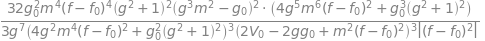

In [40]:
display((1/3*(H_proj[0][1]/V)**2*(H_proj[0][0]/V)).nsimplify().simplify())